# Doubly constrained gravity model

For a given:
* set of origins $i$ and destinations $j$ 
* production at origins vector $O_i$
* attraction at destinations vector $D_j$
* distance (cost) matrix between origins and destinations $C_{ij}$
* cost function for the decay/gravity function $T_{ij}=exp(-\beta C_{ij})$

Compute:
* trip matrix $T_{ij}$ such that
* $\sum_{i \in O} T_{ij} = O_i \forall j \in O$
* $\sum_{j \in D} T_{ij} = D_i \forall i \in D $


Plan obliczeń

1.	Get general worker flows (Xij) between zones
2.	Get production (Oik, Sijk in notation below) and attractions (Djk) for zones disaggregated by some characteristic (income, race, income-race, mode)
3.	Generate one dummy production zone and one dummy attraction zone so that (number 9 is the dummy zone based on a 8 zone toy problem: 8x8 matrix is original, 9x9 is extended matrix):


In [1]:
import osmnx as ox
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotmap import DotMap
import os
import math

let's import some network - nodes are zones of the network

In [170]:
def load_data(plot = False):
    inData = DotMap()
    d = dict()
    for file in os.listdir('./wichita'):
        if file.startswith('wichita'):
            df = pd.read_csv('wichita/{}'.format(file), header = None)

            df = pd.DataFrame(df.values.reshape(464,int(df.shape[0]/464)))
            d[file[8:-4]] = {"shape":df.shape, 'sum':df.sum().sum()}
            inData[file[8:-4]] = df
    display(pd.DataFrame(d).T) if plot else None
    return inData


/var/folders/11/v91c3qb92lg10fbgz1ptll4m0000gn/T/ipykernel_22769/3911081216.py:50: RuntimeWarning: divide by zero encountered in reciprocal
  C_ij = np.reciprocal(np.outer(O*A,D*B))
/opt/anaconda3/envs/ExMAS/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in reciprocal
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/ExMAS/lib/python3.8/site-packages/numpy/core/numeric.py:936: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)


Ite: 0	 total: 181470.79	 error_O: 24845732.16	 error_D: 222139746.92
Ite: 1	 total: 0.00	 error_O: 24359793.00	 error_D: 222360158.08
Ite: 2	 total: 0.00	 error_O: 24359793.00	 error_D: 222360158.08
Ite: 3	 total: 0.00	 error_O: 24359793.00	 error_D: 222360158.08
Ite: 4	 total: 0.00	 error_O: 24359793.00	 error_D: 222360158.08
Ite: 5	 total: 0.00	 error_O: 24359793.00	 error_D: 222360158.08
Ite: 6	 total: 0.00	 error_O: 24359793.00	 error_D: 222360158.08
Ite: 7	 total: 0.00	 error_O: 24359793.00	 error_D: 222360158.08
Ite: 8	 total: 0.00	 error_O: 24359793.00	 error_D: 222360158.08
Ite: 9	 total: 0.00	 error_O: 24359793.00	 error_D: 222360158.08
Ite: 9	 demand:89949.00	 trips: 0.00	 error_O: 24359793.00	 error_D: 222360158.08 cost mean: nan	 var: nan


/var/folders/11/v91c3qb92lg10fbgz1ptll4m0000gn/T/ipykernel_22769/3911081216.py:63: RuntimeWarning: invalid value encountered in double_scalars
  mean_cost = (H.cost*H.flow).sum()/H.flow.sum()


ValueError: weights should have the same shape as x

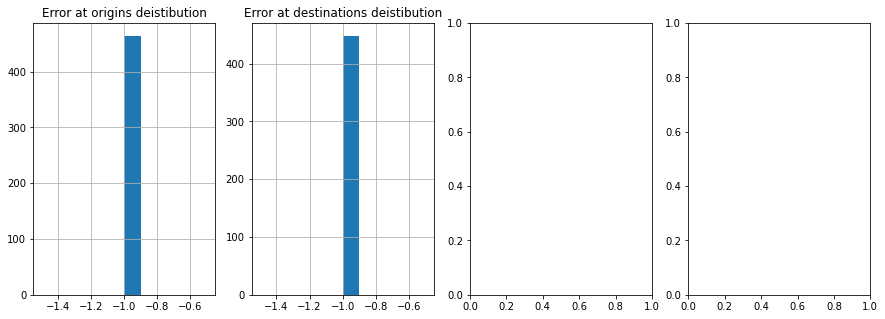

In [182]:
inData = load_data()
k = 1
O = inData.oik[k-1]
D = inData.djk[k-1]
X = inData['full_xij_k{}'.format(k)]
C = inData.dist
def triply(O, D, C, X, beta = 0.1, plot = True, normalize = True, max_ite = 10, eps = 0.01, dummy = True):
    """
    Computes trip matrix
    O - pandas series of origin flow from each zone
    D - pandas series of destination flows towards each zone
    C - cost matrix (distance) between the zones (pd.DataFrame)
    X - original flow matrix
    beta - parameter in the gravity model (enters with negative sign into the model)
    plot - flag to print iterations and plot results on the graphs
    max_ite - maximal number of iterations
    eps - error (Total Squared error) at which balancing terminates
    """
    if normalize and abs(O.sum() - D.sum()) / D.sum() > eps: # see if sums match
        D = D*O.sum()/D.sum() # adjust D to O
    
        
    def fun(x):
        return np.exp(-beta*x)
    O = O.values # rows
    A = np.ones_like(O)
    D = D.values # columns
    B = np.ones_like(D)
    X = np.ones_like(X)
    C_ij = np.ones_like(X)/10

    F = C.apply(np.vectorize(fun))
    for i in range(max_ite):
        T = np.outer(O*A,D*B)*F*C_ij*X
        
        A = np.reciprocal((B*D*F*C_ij).sum(1))
        T = np.outer(O*A,D*B)*F*C_ij*X   
        B = np.reciprocal((A*O*(F.T)*C_ij).sum(1))
        T = np.outer(O*A,D*B)*F*C_ij*X
        C_ij = np.reciprocal(np.outer(O*A,D*B))
        T = np.outer(O*A,D*B)*F*C_ij
        if max(((T.sum(1)-O)**2).sum(),((T.sum(0)-D)**2).sum()) < eps:
            break
        if plot and i % 1 ==0:
            print("Ite: {}\t total: {:.2f}\t error_O: {:.2f}\t error_D: {:.2f}".format(i,
                                                                             T.sum().sum(),
                                                                             ((T.sum(1)-O)**2).sum(),
                                                                             ((T.sum(0)-D)**2).sum()))
            
    H = T.stack().to_frame()
    H.columns = ['flow']
    H['cost'] = C.stack()
    mean_cost = (H.cost*H.flow).sum()/H.flow.sum()
    cost_var = (H.cost*H.flow).std()
    print("Ite: {}\t demand:{:.2f}\t trips: {:.2f}\t error_O: {:.2f}\t error_D: {:.2f} cost mean: {:.2f}\t var: {:.2f}".format(i,
                                                                                                                               O.sum(),
                                                                                                                               T.sum().sum(),
                                                                                                                               ((T.sum(1)-O)**2).sum(),
                                                                                                                               ((T.sum(0)-D)**2).sum(),
                                                                                                                               mean_cost, cost_var))
    if plot:
        fig, axes = plt.subplots(1,4,figsize = (15,5))
        axes = axes.flatten()
        #productions
        ((T.sum(1)-O)/O).hist(ax=axes[0]) # error at origins
        axes[0].set_title('Error at origins deistibution')
        ((T.sum(0)-D)/D).hist(ax=axes[1]) # error at destinations
        axes[1].set_title('Error at destinations deistibution')
        H['flow'].plot(kind='hist', weights = H['cost'], ax = axes[2], bins = 100) # trip distance distribution
        axes[2].set_xlim(0,H['flow'].quantile(0.99))
        axes[2].set_title('Trip distance distribution')
        
        
        x=np.linspace(C.min().min(),C.max().max(), 200)
        axes[3].plot(x,fun(x))
        axes[3].set_title('Theoretical impedance')

    return T
T = triply(O, D, C, X, beta = 0.01, plot = True, normalize = True, dummy = False)

In [47]:
T.round(2)

,0,1,2,3,4,5,6,7,8,9,...,454,455,456,457,458,459,460,461,462,463
0,0.07,0.19,0.18,0.20,0.03,0.34,0.02,0.25,0.54,0.86,...,0.00,0.00,0.05,0.00,0.02,0.03,0.21,0.02,0.14,0.09
1,0.05,0.18,0.15,0.16,0.02,0.25,0.01,0.22,0.48,0.72,...,0.00,0.00,0.04,0.00,0.01,0.02,0.20,0.02,0.13,0.08
2,0.11,0.35,0.32,0.33,0.04,0.56,0.03,0.43,0.98,1.57,...,0.01,0.01,0.09,0.01,0.03,0.05,0.39,0.04,0.26,0.16
3,0.12,0.39,0.33,0.47,0.05,0.57,0.03,0.55,1.02,1.61,...,0.01,0.01,0.09,0.01,0.03,0.05,0.43,0.04,0.28,0.17
4,0.08,0.22,0.20,0.23,0.03,0.36,0.02,0.29,0.60,0.96,...,0.01,0.01,0.05,0.00,0.02,0.03,0.24,0.02,0.16,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,0.05,0.19,0.16,0.17,0.02,0.30,0.02,0.23,0.64,0.79,...,0.01,0.01,0.07,0.01,0.02,0.04,0.33,0.03,0.22,0.14
460,0.02,0.09,0.07,0.08,0.01,0.13,0.01,0.10,0.28,0.35,...,0.00,0.00,0.04,0.00,0.01,0.02,0.18,0.02,0.12,0.07
461,0.02,0.07,0.06,0.07,0.01,0.11,0.01,0.09,0.24,0.30,...,0.00,0.00,0.03,0.00,0.01,0.02,0.15,0.02,0.10,0.06
462,0.05,0.19,0.16,0.17,0.02,0.30,0.02,0.23,0.64,0.79,...,0.01,0.01,0.09,0.01,0.02,0.04,0.40,0.04,0.28,0.17


----
(c) Rafal Kucharski, 2022